# İş Akışı ve Hiperparametre Optimizasyonu

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

🏠 Ev fiyatları veri setini içe aktarın. Basitlik adına sadece sayısal özellikleri tutacağız

🎯 Hedefiniz en iyi KNN Regressor'ı yerleştirmek olacak. Özellikle, ev fiyatlarınız için en iyi tahminleri elde etmek üzere kaç tane "komşu" (<font color=blue>K</font>NN'deki <font color=blue>K</font>) göz önünde bulundurmalısınız?

In [2]:
# Load raw data
data = pd.read_csv('https://d32aokrjazspmn.cloudfront.net/materials/houses_train_raw.csv', index_col="Id")

# Only keep numerical columns and raws without NaN
data = data.select_dtypes(include=np.number).dropna()

data

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,40,0,0,0,0,0,8,2007,175000
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,349,0,0,0,0,0,0,2,2010,210000
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,60,0,0,0,0,2500,5,2010,266500


In [3]:
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']

## 1. Eğitim/Test Ayrımı

❓ **Soru (Holdout)**❓

👇 `X_train`, `X_test`, `y_train` ve `y_test` oluşturmak için veri setini böl. Şunları kullan:
- `test_size=0.3`
- Sonuçlarınızı arkadaşınızla karşılaştırmak için `random_state=0`

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, 
                                                    random_state = 0)

## 2. Ölçeklendirme

⚖️ Ölçeklendirme KNN algoritması için her zaman kritik derecede önemlidir..

❓ **Soru (Ölçeklendirme)** ❓ 

* Eğitim setinizi ve test setinizi ölçeklendirin.
* Burada, basitçe `StandardScaler` uygulayalım ve özellik başına bir ölçekleyici seçerek zaman kaybetmeyelim. Gerçekten de, bu egzersizin amaçları şunlardır:
    * KNN'i gözden geçirmek
    * GridSearchCV'yi anlamak
    * RandomizedSearchCV'yi anlamak

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)

## 3. Temel KNN modeli

❓ **Soru (KNN için bir temel)** ❓

Sadece _en yakın komşuyu_ dikkate alan basit bir KNN regressor'ı çapraz doğrulayın (*cv = 5*) ve 5 kat üzerindeki ortalama skoru hesaplayın.

In [39]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate

knn = KNeighborsRegressor(n_neighbors=1)
cross_validate(knn, X_train_scaled, y_train, cv=5)["test_score"].mean()

0.5601542887874071

## 4. GridSearch

### 4.1. İlk GridSearch

❓ **Soru (GridSearch v1)**❓

En iyi KNN hiperparametresini `n_neighbors` bulmak için SKLearn `GridSearchCV` kullanalım.
- `n_neighbors` = [1,5,10,20,50] ile kaba taneli bir yaklaşım başlat
- Her parametreyi 5-kat çapraz doğrula
- `n_jobs` kullanarak performans sürenizi maksimize ettiğinizden emin olun

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()
k_grid = {'n_neighbors' : [1,5,10,20,50]}
grid = GridSearchCV(model, k_grid, n_jobs=-1,  cv = 5)
grid.fit(X_train_scaled, y_train)


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 5, 10, 20, 50]})

❓ **Soru (en iyi parametreler)** ❓

GridSearch'e göre, optimal K değeri nedir?

In [41]:
grid.best_params_['n_neighbors']


10

❓ **Soru (puanlama)** ❓ Optimal K değerinin ürettiği en iyi skor nedir?

In [42]:
grid.best_score_


0.7596697382171873

### 4.2. İkinci GridSearch

❓ **Soru (GridSearch V2)** ❓

Şimdi, en iyi $K$'nın nerede olduğu hakkında bir fikrimiz var, ancak denemediğimiz bazı değerler daha iyi bir performansla sonuçlanabilir.

* Önceki en iyi değerinizin çevresindeki $K$ için bazı değerleri deneyerek GridSearch'ü yeniden çalıştırın
* Bu rafine edilmiş GridSearch için `best_score` ve `best_k` nelerdir?

In [43]:
model = KNeighborsRegressor()
k_grid = {'n_neighbors' : np.arange(11,30,1)}
grid = GridSearchCV(model, k_grid, n_jobs=-1,  cv = 5)
grid.fit(X_train_scaled, y_train)

print(grid.best_params_["n_neighbors"])
print(grid.best_score_)


16
0.7666311417513013


In [46]:
best_k = grid.best_params_["n_neighbors"]
best_score = grid.best_score_

***🧪 Kodunuzu test edin***

In [47]:
from nbresult import ChallengeResult
result = ChallengeResult('knn',
                         best_k=best_k,
                         best_score=best_score)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/dilay/.pyenv/versions/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/dilay/Desktop/D16D5-S-data-workflow/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_knn.py::TestKnn::test_best_k PASSED                                 [ 50%]
test_knn.py::TestKnn::test_best_score PASSED                             [100%]

============================== 2 passed in 0.07s ===============================



### 4.3. Görsel kontrol (manuel GridSearch)

☝️ Bu problem aslında manuel olarak GridSearch yapmak için yeterince basittir.

❓ **Soru(Manuel GridSearch)** ❓

- $K$'nın $1$'den $50$'ye kadar tüm değerleri üzerinde manuel olarak döngü yapın ve her modelin çapraz doğrulanmış skorlarının ortalamasını bir listede saklayın.
- `Dirsek Yöntemi` kullanarak en iyi $K$'yı görsel olarak bulmak için skorları $K$'nın bir fonksiyonu olarak çizin

In [48]:
scores=[]
for k in range(1,50):
    knn = KNeighborsRegressor(n_neighbors=k)
    scores.append(cross_validate(knn, X_train_scaled, y_train, cv=5)["test_score"].mean())

❓GridSearchCV'yi böyle bir manuel döngüden daha iyi bir seçenek yapan şeyi tahmin edebilir misiniz?

<details>
    <summary>Cevap</summary>

- Sklearn'ın `n_jobs=-1` seçeneği aramayı paralelleştirmenize izin verir, tüm CPU çekirdeklerinizi kullanır
- Birlikte optimize edilecek birden fazla hiperparametreniz olsaydı ne olurdu?
</details>

## 5. Birden çok parametre ile GridSearch

👩🏻‍🏫 KNNRegressor, `p` hiperparametresi aracılığıyla çeşitli _mesafe metrikleri_ destekler

📚 [sklearn.neighbors.KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

❓ **Soru (birden çok parametreyi ayarlama)** ❓

* En iyi $K$ ve $p$'yi aynı anda aramak için GridSearchCV kullanın.
    * $K = [1, 5, 10, 20, 50]$ ve $p = [1, 2, 3]$ için tüm kombinasyonları deneyin.

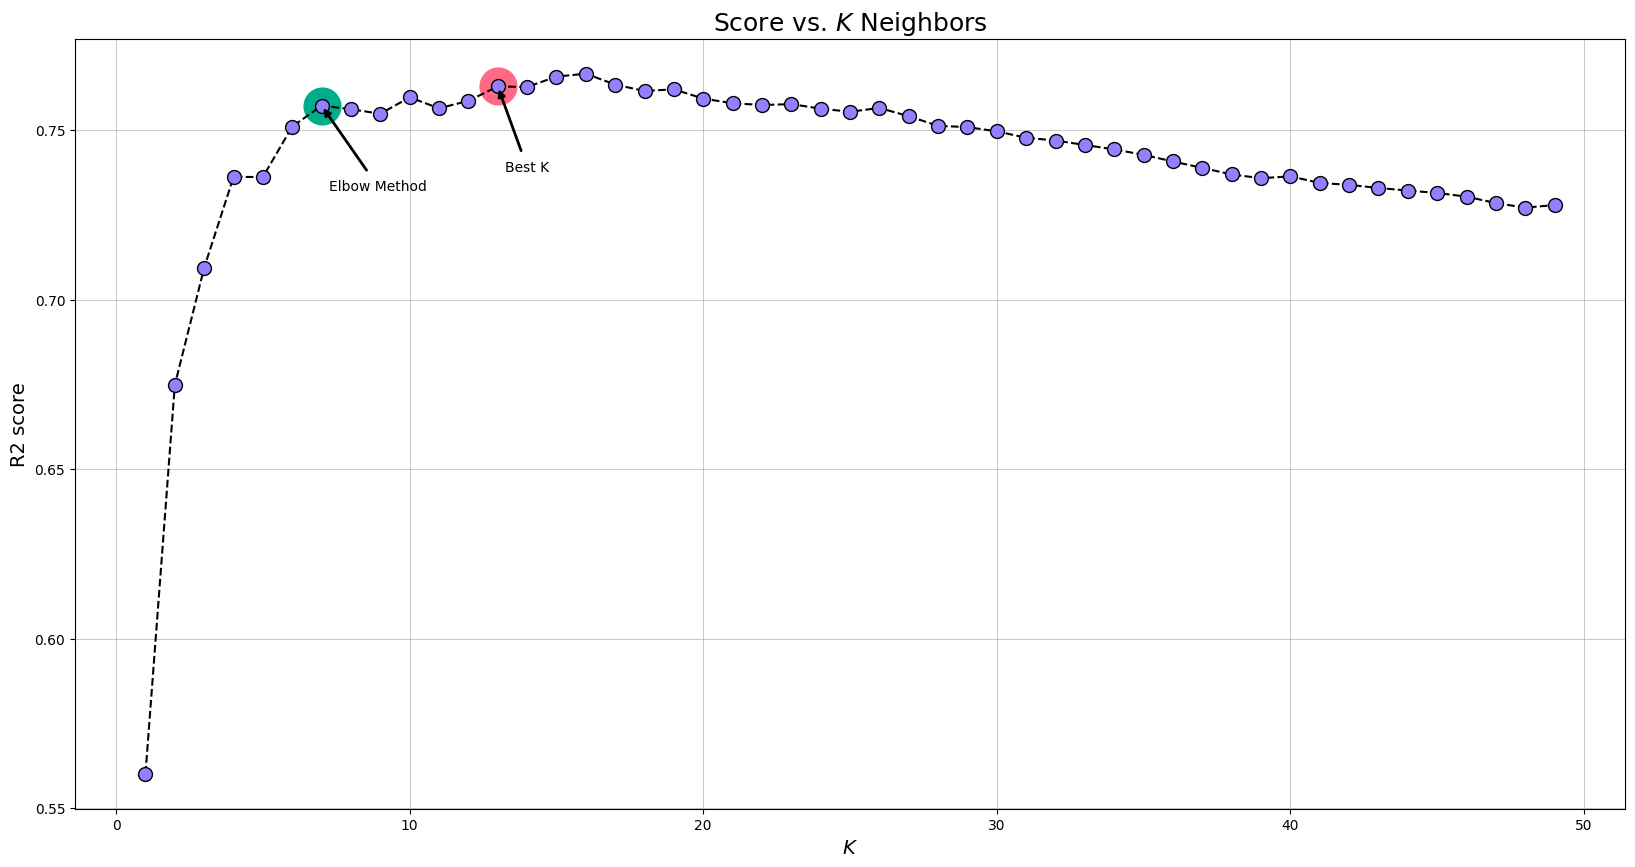

In [49]:
import matplotlib.pyplot as plt

with plt.style.context('fast'):
    plt.figure(figsize=(20,10))
    ax = plt.gca()
    ax.plot(range(1,50),scores,color='black', linestyle='dashed', marker='o',markerfacecolor='#947FFF', markersize=10)
    ax.set_title('Score vs. $K$ Neighbors', fontsize = 18)
    ax.set_xlabel('$K$', fontsize = 14)
    ax.set_ylabel('R2 score', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.scatter(7,scores[7-1],c='#00ad8b',s=700)
    ax.scatter(13,scores[13-1],c='#ff6984',s=700)

    ax.annotate("Elbow Method", 
                xy=(7,scores[7-1]),
                xytext=(7+0.25,scores[7-1]-0.025), 
                arrowprops=dict(arrowstyle='-|>',
                                fc="k",
                                ec="k",
                                lw=2),
                bbox=dict(pad=5, facecolor="none", edgecolor="none")
               )
    
    ax.annotate("Best K", 
            xy=(13,scores[13-1]),
            xytext=(13+0.25,scores[13-1]-0.025), 
            arrowprops=dict(arrowstyle='-|>',
                            fc="k",
                            ec="k",
                            lw=2),
            bbox=dict(pad=5, facecolor="none", edgecolor="none")
           )
    
    
    plt.show()

❓ **Soru (alt model sayısı)**❓

Toplamda kaç alt model eğittiniz?

<details>
    <summary>İpucu</summary>

15'ten çok daha fazla. İki kez düşün :)
    <details>
    <summary>Cevap</summary>

CV=5 nedeniyle 75 model
</details>

75

❓ **Soru (modeli birden çok parametre ile ayarladıktan sonra en iyi parametreler ve en iyi skor)**❓

*En iyi parametreler* ve *en iyi skor* nedir?

In [51]:
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 10, 'p': 1}
0.7969255879201194


## 6. Rastgele Arama

Şimdi bir RandomizedSearch'ün aynı sayıda model yerleştirilerek daha iyi bir kombinasyon bulup bulamayacağını görelim.

❓ **Soru (RandomizedSearchCV)** ❓

`RandomizedSearchCV` kullanarak
- $K$'yı uniform `scipy.stats.randint(1,50)` ([döküman](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.randint.html)) dağılımından rastgele örnekle
- $p$'yi $[1,2,3]$ listesinden örnekle
- Önceki GridSearchCV'nizdeki ile tam olarak aynı sayıda model yerleştirmek için doğru `n_iter` ve `cv` sayılarını kullanın.

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

model = KNeighborsRegressor()

search_space = {'n_neighbors': randint(1, 50), 'p': [1, 2, 3]}

search = RandomizedSearchCV(model, param_distributions=search_space,
                            n_jobs=-1,  
                            cv=5, 
                            n_iter=15)

search.fit(X_train_scaled, y_train)

print(search.best_score_)
print(search.best_params_)

0.7769644500406202
{'n_neighbors': 22, 'p': 1}


## 7. Genelleme

❓ **Soru (modelinizi bir kez daha ince ayarlama)**❓

- İsterseniz RandomsearchCV'nizi rafine edin
- En iyi modelinizi seçin

In [54]:
best_model = search.best_estimator_

Şimdi `cv_results`'ınızı bir `DataFrame` olarak görüntülemeye çalışın, bu CV'nin içinde neler olup bittiğini görselleştirmenize yardımcı olacak! 😉

In [55]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001202,0.000225,0.034802,0.005513,45,3,"{'n_neighbors': 45, 'p': 3}",0.699392,0.766606,0.649305,0.736509,0.655298,0.701422,0.045448,14
1,0.001814,0.000256,0.003261,0.001088,3,2,"{'n_neighbors': 3, 'p': 2}",0.636549,0.766632,0.667702,0.856522,0.619653,0.709412,0.089466,13
2,0.001356,0.000478,0.001934,0.000373,25,2,"{'n_neighbors': 25, 'p': 2}",0.739938,0.812000,0.699433,0.800460,0.725192,0.755405,0.043630,3
3,0.000775,0.000280,0.001530,0.000087,30,2,"{'n_neighbors': 30, 'p': 2}",0.737478,0.800830,0.697597,0.786169,0.726074,0.749629,0.038384,6
4,0.001121,0.000582,0.031435,0.004830,37,3,"{'n_neighbors': 37, 'p': 3}",0.706299,0.773799,0.657572,0.750440,0.663685,0.710359,0.046070,12
5,0.000924,0.000487,0.030281,0.004759,11,3,"{'n_neighbors': 11, 'p': 3}",0.711697,0.776643,0.680999,0.800026,0.687919,0.731457,0.048115,10
6,0.000820,0.000445,0.001432,0.000165,25,2,"{'n_neighbors': 25, 'p': 2}",0.739938,0.812000,0.699433,0.800460,0.725192,0.755405,0.043630,3
7,0.001129,0.000489,0.002305,0.000730,44,2,"{'n_neighbors': 44, 'p': 2}",0.731559,0.787225,0.685035,0.761983,0.695017,0.732164,0.038787,9
8,0.001118,0.000321,0.004281,0.001478,22,1,"{'n_neighbors': 22, 'p': 1}",0.768409,0.811100,0.721044,0.822713,0.761557,0.776964,0.036595,1
9,0.001493,0.000463,0.003447,0.001716,48,2,"{'n_neighbors': 48, 'p': 2}",0.729806,0.779704,0.681233,0.756216,0.688619,0.727116,0.037965,11


❓ **Soru ("En iyi" modelin değerlendirmesi)** ❓

* "En iyi parametrelerle" modelimizin **görülmemiş** test seti `X_test` üzerindeki performansını keşfetme zamanı geldi.
    * Test seti için r2 skorunu hesaplayın ve `r2_test` olarak kaydedin.

In [56]:
from sklearn.metrics import r2_score

r2_test = r2_score(y_test, best_model.predict(scaler.transform(X_test)))
r2_test

/Users/dilay/.pyenv/versions/workintech/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


0.7665754763419822

❓ **Soru (Bir adım geri çekilme)** ❓

Optimize edilmiş modelin iyi genelleme yaptığını düşünür müsünüz?

<details><summary>Cevap</summary>

Test skoru eğitim seti ile biraz azalabilir. Muhtemelen %5'ten fazla değil. Bunun nedeni şunlar olabilir:
- Temsili olmayan bir eğitim/test bölünmesi
- Model ayarlama aşamasında aşırı öğrenmeye yol açan çok küçük bir çapraz doğrulama sayısı. Ne kadar çok çapraz doğrulama yaparsanız, bulgularınız o kadar güçlü genelleşir - ancak veri setiniz çok küçükse cv'yi çok fazla artıramazsınız çünkü her katmanda temsili olmak için yeterli gözlemi tutamazsınız.
- Veri setimiz çok küçük ve hiperparametre optimizasyonumuz bu nedenle eğitim/test bölünmemize son derece bağımlı (ve aşırı uyum gösteriyor). Veri setinizin denediğiniz toplam hiperparametre kombinasyonu sayısından çok daha büyük olduğundan her zaman emin olun!
    
</details>

***🧪 Kodunuzu test edin***

In [57]:
from nbresult import ChallengeResult
result = ChallengeResult('r2', 
                         r2_test=r2_test)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/dilay/.pyenv/versions/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/dilay/Desktop/D16D5-S-data-workflow/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_r2.py::TestR2::test_r2 PASSED                                       [100%]

============================== 1 passed in 0.01s ===============================



🏁 Tebrikler! Artık GridSearchCV veya RandomizedSearchCV kullanarak bir modeli nasıl ince ayarlayacağınızı biliyorsunuz

💾 Notebook'unuzu `git add/commit/push` yapmayı unutmayın...

🚀 ... ve bir sonraki meydan okumaya geçin!